# Introduction to convolutional neural network

Here's we what are going to do in this notebook:

1. Get to know **deep neural network** (DNN)
2. Get to know **convolutional neural network** (CNN)
    - Motivation for CNN
    - Key components that define a CNN
3. Build a simple CNN **image classifier** using `tensorflow.keras`

## Deep neural network

Let's first see the big picture.

Wikipedia: **Machine learning** (ML) is the study of computer algorithms that improve automatically through experience.

Machine learning is often sliced into

* Supervised learning (predicting a label, i.e. classification, or a continuous variable),
* Unsupervised learning (pattern recognition for unlabeled data, e.g., clustering),
* Reinforcement learning (algorithms learn the best way to "behave", e.g. AlphaGo Zero, self-driving cars). 

Deep learning is a powerful form of machine learning that has garnered much attention for its successes in computer vision (e.g. image recognition), natural language processing, and beyond. 

DNN is probably the most well-known network for deep learning.
- Originally inspired by information processing and communication nodes in biological systems.
- Input data is passed through layers of the network, which contain a number of nodes, analogous to "neurons". 
- DNN systems can be trained to learn the features of the data very well.

![Deep neural network](../img/deep-nn.jpg)
Image credit: Waldrop, M. M. (2019). News Feature: What are the limits of deep learning?. Proceedings of the National Academy of Sciences, 116(4), 1074-1077.

Roughly speaking, there are two important operations that make a neural network.
1. **Forward propagation**
2. **Backpropagation**

### Forward propagation
+ The network reads the input data, computes its values across the network and gives a final output value.
+ This is the **prediction** step.

How does the network computes an output value?

Let's see what happens in a single layer network when it does one prediction.
1. Inputs: a vector of numbers.
2. Weights: each node has its own weight.
3. Weighted sum: as the name suggests, a weighted sum of the inputs.
3. Activation: the weighted sum is "activated" through a (usually nonlinear) activation function, e.g. step function.

![title](../img/perceptron.jpg)

Image [credit](https://deepai.org/machine-learning-glossary-and-terms/perceptron).

If you know a bit about algebra, this is what the operation is doing:
- $y = f(\mathbf{w}\cdot \mathbf{x} + b) $

where $\mathbf{w}\cdot \mathbf{x} + b$ is the weighted sum, $f(\cdot)$ is the activation function, and $y$ is the output.

Now, in a deeper neural network, the procedure is essentially the same. The input --> weighted sum --> activation process is done for each layer. 

![title](../img/mlp.png)

Image [credit](https://www.cs.purdue.edu/homes/ribeirob/courses/Spring2020/lectures/03/MLP_and_backprop.html).

### Backpropagation

+ By comparing the predictions and the ground truth values (loss), the network adjusts its parameters so that the performance is improved. 
+ This is the **training** step.

How does the network adjust the weights through training?

This is done through an operation called **backpropagation**, or backprop. The network takes the loss and recursively calculates the slope of the loss function with respect to each network parameter. Calculating these slopes requires the usage of chain rule from calculus, you can read more about it [here](https://sebastianraschka.com/faq/docs/backprop-arbitrary.html).

An optimization algorithm is then used to update network parameters using the gradient information until the performance cannot be improved anymore. One commonly used optimizer is stochastic gradient descent. 

One analogy often used to explain gradient-based optimization is hiking:
+ Training the network so that its loss is minimized is like trying to get down to the lowest point on the ground from a mountain.
+ Backprop operation finding the loss function gradients is like finding the path on your way down.
+ Optimization algorithm is the step where you actually take the path and eventually reach the lowest point.

![title](../img/gradient-descent.png)
Image [credit](https://www.datasciencecentral.com/profiles/blogs/alternatives-to-the-gradient-descent-algorithm).

So now you know that DNN
- is a powerful **machine learning** technique
- can be used to tackle **supervised**, **unsupervised** and **reinforcement learning** problems
- consists of forward propagation (**input to output**) and backpropagation (**error to parameter update**)

We are ready to talk about CNN!

## Convolutional neural network

Ordinary neural networks that we've talked about above expect input data to be a **vector of numbers**:
$\mathbf{x} = [x_1, x_2, x_3, \dots]$

What if we want to train an **image classifier**, i.e. use image as the input?

### Motivation

Digital image basics:
- An image is a **collection of pixels**. For example, a 32-by-32 image has $32 \times 32 = 1024$ pixels.
- Each pixel is an **intensity represented by a number** in the range $[0, 255]$, $0$ is black and $255$ is white.
- Color images have three dimensions: **[width, height, depth]** where depth is usually 3.
- Why is depth 3? That's because it encodes the intensity of [**R**ed, **G**reen, **B**lue], i.e. RGB values. 


Therefore, to a computer program, this black and white Lincoln image is just a matrix of integers. 
![image](../img/image_pixel.png)
Image [credit](https://ai.stanford.edu/~syyeung/cvweb/tutorial1.html)

We could also easily generate a random picture by random numbers.

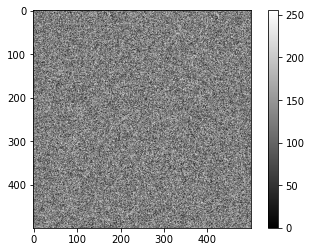

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a 500-by-500 matrix with random integers between 0 and 255
random_image = np.random.randint(low=0, high=256, size=[500, 500])

# Plot the random image
plt.imshow(random_image, cmap='gray')
plt.colorbar();

Since a digital image can be represented as a 2D grid of pixel values, we could stretch out the grid, make it into a vector of numbers and feed it into a neural network.

However, there are two major limitations to this approach.

1. **It does not scale well to bigger images.**
    + While it is still manageable for an input with $32\times32 = 1024$ dimensions, most real-life images are bigger than this. 
    + For example, a color image of size 320x320x3 would translate to an input with dimension **307200**!  
    
2. **It does not consider the properties of an image.**
    + *Locality*: Nearby pixels are usually strongly correlated (e.g., see the face outline above). Stretching it out breaks the pattern.     
    + *Translation invariance*: Meaningful features could occur anywhere on an image, e.g., see the flying bird. 
![bird](../img/flying-bird.png)
    
Image [credit](https://storage.googleapis.com/deepmind-media/UCLxDeepMind_2020/L3%20-%20UUCLxDeepMind%20DL2020.pdf)

### Convolution

On the other hand, CNN is designed to scale well with images and take advantage of these unique properties.

1. **Weight sharing**: All local parts of the image are processed with the same weights so that identical patterns could be detected at many locations, e.g., horizontal edges, curves and etc.
2. **Hierarchy of features**: Lower-level patterns are composed to form higher-level ones, e.g., edges --> contour --> face outline

This is done through the operation of **convolution**:

1. Define a filter: a 2D weight matrix of a certain size.
2. Convolve the whole image with the filter: multiply each pixel under the filter with the weight.
3. Convolution output forms a new image: a feature map.
4. By using multiple filters (each with a different weight matrix), different features can be captures.

####  Example: mean filter

Actually, let's see the operation in numbers and images. It will be easier to see. 

Here we create an image of a bright square. Note that `matplotlib` automatically interprets values in [0,1] the same as in [0, 255].

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


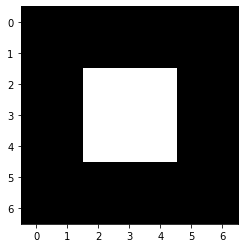

In [10]:
bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1

print(bright_square)

fig, ax = plt.subplots()
ax.imshow(bright_square, cmap='gray');

Recall that a filter is a 2D weight matrix. Let's create one example filter, and call it the **"mean filter"**.

In [40]:
mean_filter = np.full((3, 3), 1/9)

print(mean_filter)

[[0.11 0.11 0.11]
 [0.11 0.11 0.11]
 [0.11 0.11 0.11]]


Here we convolve the image with the filer and print out both the original and convolved image. 

In [87]:
import scipy.ndimage as ndi
%precision 2

# print original image pixel values
print('Original image pixel values: \n', bright_square)

# print convolved image pixel values
filtered_square = ndi.convolve(bright_square, mean_filter)
print('\n Filtered image pixel values: \n', filtered_square)

Original image pixel values: 
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]

 Filtered image pixel values: 
 [[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.33 0.67 1.   0.67 0.33 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


In a convolution, this "mean filter" actually slides across the image and takes the values of 9 connected pixels and average them out.
![title](../img/convolution.gif)

Let's see how the convolved image looks like. You could probably see why this is called the "mean filter" now.

It returns an image whereby each pixel is an average of 9 pixels on the original image. It kind of blurs out any edges in the image. 

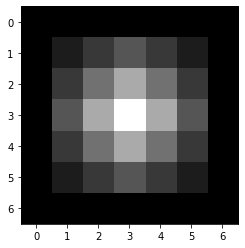

In [88]:
fig, ax = plt.subplots()
ax.imshow(filtered_square, cmap='gray');

You can read about convolution, filtering, edge detection and more [here](https://ai.stanford.edu/~syyeung/cvweb/tutorial1.html).

**What's this to do with a convolutional neural network?**

CNN applies the same convolution procedure, but the key difference is it **learns the filter weights** through backpropagation (training). 

- For each layer, there are usually many filters, each with a different weight matrix, applied to the same image. Each filter would capture a different pattern of the same image.
- A CNN could also have many layers of convolution. The complexity of the network allows features at different scales to be captured. 

For example, here's an illustration of features learned by filters from early to latter part of the network.  
- Early filters capture edges and textures. (**General**)
- Latter filters form parts and objects. (**Specific**)

![title](../img/feature.png)
Image [credit](https://distill.pub/2017/feature-visualization/)

### Key features of CNN

While DNN uses many fully-connected layers, CNN contains mostly convolutional layers. 

1. In its simplest form, CNN is a list of layers that transform an image to a list of class probabilities. 
2. Some of the most popular types of layers are:
    - **Convolutional layer** (CONV): image undergoes a convolution with filters.
    - **RELU layer** (RELU): element-wise nonlinear activation function (same as those in DNN before).
    - **Pooling layer** (POOL): image undergoes a convolution with a mean (or max) filter, so it's down-sampled.
    - **Fully-connected layer** (FC): usually used as the last layer to output a class probability prediction.

Now, if you are *designing your own CNN*, there are many elements to play with. They generally fall into two categories:

1. Type of convolutional layer
    - **Depth**: number of filters to use for each layer
    - **Stride**: how big of a step to take when sliding the filter across the image, usually 1 (see the convolution GIF above) or 2.
    - **Size**: size of each convolution filter, e.g., the mean filter is 3-by-3.
    - **Padding**: whether to use paddings around images when doing convolution. This determines the output image size. 
    - And others.
2. How to connect each layer
    - The actual architecture of your CNN. 
        - This is an active field of research, e.g. what's a better architecture? or can we automatically search for a better architecture? Check "neural architecture search" out if you are interested.
    - A commonly used architecture goes like this:
        - $\text{INPUT} \rightarrow [ [\text{CONV} \rightarrow \text{RELU}]^N \rightarrow \text{POOL}]^M \rightarrow [\text{FC} \rightarrow \text{RELU}]^K \rightarrow \text{FC}$
        - The power $N, M, K$ means that the operation is repeated those number of times.

# What's next?

In the next notebook, `2-COVID-19-classification-based-on-CT-scan`, we are going to explore how CNN can be used to build a **COVID-19 CT scan image classifier**. 

This classifier can take in an unknown patient's CT scan, and predicts if the patient has COVID-19 or not.

# Further resources

You can learn more about CNN 👉:
- [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/)
- [DeepMind x UCL | Convolutional Neural Networks for Image Recognition
](https://www.youtube.com/watch?v=shVKhOmT0HE&ab_channel=DeepMind)

and how to implement them 👉:
- [Introduction to Keras for Engineers
](https://keras.io/getting_started/intro_to_keras_for_engineers/)
- [Tensorflow Keras CNN Guide](https://www.tensorflow.org/tutorials/images/cnn)

Enjoy! 👏👏👏